Описание
========

Используется velocity motion model: если в момент $ t $ пришло управляющее воздействие $ (v, \omega) $, то значит, что с этими параметрами мы едем до следующей отметки времени. Время задано в некоторых условных единицах, скорость и угловая скорость в метрах на условную единицу и радиан на условную единицу соответственно.

Показания находятся в файле __timeline.json__ в виде [[events for time 0], [events for time 1], ...]. events - массив показаний.

Порядок действий:
1. Создать все вершины для оптимизации (позы машинки)
2. Написать функцию ошибки одометрического ребра
3. Написать обработчик, который из потока событий собирает одометрические ребра
4. Вернуть ограничения из обработчика событий
5. Реализовать prior-ребро , притягивающее машину к начальному положению и через обработчик добавить в граф

In [1]:
from __future__ import division, print_function, absolute_import
import numpy as np
from matplotlib import pyplot as plt
from operator import itemgetter, attrgetter
import itertools as it
import json
%matplotlib inline

In [2]:
class Visualizator(object):
    MIN_SIZE = 10
    
    def __init__(self, margin=40.0, grid=False):
        self._plot_margin = margin
        self._grid = grid
        self._positions = None
        self._points = None
        self._lines = None

    def update_poses(self, poses):
        self._positions = poses[:, :2]
    
    def update_features(self, features):
        self._points = []
        self._lines = []
        for feature in features:
            if feature.ftype == Feature.POINT:
                self._points.append(feature.visualization_data)
            elif feature.ftype == Feature.LINE:
                self._lines.append(feature.visualization_data)
        if len(self._points) == 0:
            self._points = None
        else:
            self._points = np.array(self._points)
        if len(self._lines) == 0:
            self._lines = None
        else:
            self._lines = np.array(self._lines)
    
    def show(self, title=None):
        bounds = self._determine_bounds()
        bounds_size = (bounds[2] - bounds[0], bounds[3] - bounds[1])
        aspect = bounds_size[0] / bounds_size[1]
        if 1.0 < aspect: 
            plt.figure(figsize=(aspect * Visualizator.MIN_SIZE, Visualizator.MIN_SIZE))
        else:
            plt.figure(figsize=(Visualizator.MIN_SIZE, Visualizator.MIN_SIZE / aspect))
        plt.axis([bounds[0] - self._plot_margin,
                  bounds[2] + self._plot_margin,
                  bounds[1] - self._plot_margin,
                  bounds[3] + self._plot_margin])
        if self._grid:
            plt.grid()
        if title is not None:
            plt.title(title)
        if self._positions is not None:
            plt.plot(self._positions[:, 0], self._positions[:, 1], 'b^')
        if self._points is not None:
            plt.plot(self._points[:, 0], self._points[:, 1], 'r.')
        if self._lines is not None:
            for line in self._lines:
                plt.plot([line[0], line[2]], [line[1], line[3]], 'g')
        plt.show()
        plt.close()

    def _determine_bounds(self):
        all_points = []
        if self._positions is not None:
            all_points.append(self._positions)
        if self._points is not None:
            all_points.append(self._points)
        if self._lines is not None:
            all_points.append(self._lines[:, :2])
            all_points.append(self._lines[:, 2:])
        all_points = np.concatenate(all_points, axis=0)
        return np.array(all_points.min(axis=0).tolist() + all_points.max(axis=0).tolist())

In [3]:
def error(state_prev, state, control, eps=1e-7):
    x, y, theta = state
    v, w = control
    xp, yp, thetap = state_prev
    
    numer = ((xp - x) * np.cos(thetap) + (yp - y) * np.sin(thetap))
    denom = 2 * ((yp - y) * np.cos(thetap) - (xp - x) * np.sin(thetap))
    
    inv_u = denom / numer
    print(numer, denom, inv_u)
    
    if abs(inv_u) < eps:
        vstar = np.sqrt((xp - x)**2 + (yp - y)**2)
        wstar = 0.
    else:
        center_x = (x + xp) / 2 + (yp - y) / inv_u
        center_y = (y + yp) / 2 + (x - xp) / inv_u
        
        r = np.sqrt((xp - center_x)**2 + (yp - center_y)**2)
        print(center_x, center_y, r)
        dtheta = np.arctan2(y - center_y, x - center_y) - np.arctan2(yp - center_y, xp - center_y)
        vstar = dtheta * r # time is 1
        wstar = dtheta
        print(dtheta, vstar, wstar)
    gammastar = (theta - thetap) - wstar
        
    return np.array([vstar - v, wstar - w, gammastar])

In [4]:
def bring_to_closest(beg, dst, base=2*np.pi):
    return beg + base * round((dst - beg) / base) 

In [73]:
class Transform2D(object):
    def __init__(self, R, t):
        self._R = R
        self._t = t
        
    @classmethod
    def from_pose(cls, pose):
        sin_yaw = np.sin(pose[2])
        cos_yaw = np.cos(pose[2])
        R = np.array([cos_yaw, -sin_yaw, sin_yaw, cos_yaw]).reshape((2, 2))
        t = np.array(pose[:2])
        return cls(R=R, t=t)
    
    def transform(self, point):
        return np.dot(self._R, point) + self._t
    
    def inverse(self):
        return Transform2D(R=self._R.T, t=-np.dot(self._R.T, self._t))

    
class Edge(object):
    def __init__(self, vertices):
        self.vertices = vertices
        self._J = None
        self.inf = None
    
    def linearize(self):
        DELTA = 1E-9
        self._J = []
        for vertex in self.vertices:
            J = None
            start_params = vertex.params
            for dim in range(vertex.dim):
                vertex.params = start_params
                delta_params = np.zeros(vertex.dim)
                delta_params[dim] = DELTA
                vertex.update(delta_params)
                self.compute_error()
                error_diff = self.error
                vertex.params = start_params
                delta_params[dim] = -DELTA
                vertex.update(delta_params)
                self.compute_error()
                error_diff -= self.error
                if J is None:
                    J = np.zeros((len(error_diff), vertex.dim))
                J[:, dim] = error_diff / 2.0 / DELTA
            self._J.append(J)

        
    def J(self, vertex_index):
        assert self._J is not None and vertex_index < len(self._J)
        return self._J[vertex_index]
    
    @property
    def inf(self):
        raise Exception('Not implemented')
    
    @property
    def error(self):
        raise Exception('Not implemented')
    
    def compute_error(self):
        raise Exception('Not implemented')
    
    def chi2(self):
        return np.dot(np.dot(self.error, self.inf), self.error)


class LinkEdge(Edge):
    inf = None
    error = None
    
    def __init__(self, vertex, event): 
        super(LinkEdge, self).__init__([vertex])
        self._vertex = vertex
        self._event = event  # pose event
        
        self.inf = np.diag([1e3] * 3)
        
    def compute_error(self):
        self.error = np.asarray(self._vertex.params) - np.asarray(self._event['pose'])
        # print(self.error)
        
class OdometryEdge(Edge):
    inf = None
    error = None

    def __init__(self, from_vertex, to_vertex, event, err_eps=1e-10):
        super(OdometryEdge, self).__init__([from_vertex, to_vertex])
        alpha = np.array(event['alpha']).reshape((3, 2))
        self.inf = np.diag(1.0 / np.dot(alpha, np.square(np.array(event['command']))))
        self._v, self._w = event['command']
        self._err_eps = err_eps
    
    @property
    def from_vertex(self):
        return self.vertices[0]
    
    @property
    def to_vertex(self):
        return self.vertices[1]
    
    def compute_error(self):
        x, y, theta = self.to_vertex.params
        xp, yp, thetap = self.from_vertex.params
        v, w = self._v, self._w
        
        numer = ((xp - x) * np.cos(thetap) + (yp - y) * np.sin(thetap))
        denom = 2 * ((yp - y) * np.cos(thetap) - (xp - x) * np.sin(thetap))

        inv_u = denom / numer

        if abs(inv_u) < self._err_eps:
            vstar = np.sqrt((xp - x)**2 + (yp - y)**2)
            wstar = theta - thetap
            gammastar = 0.
            # print('w eq 0: v*={}, v={}, w*={}, w={}'.format(vstar, v, wstar, w))
        else:
            center_x = (x + xp) / 2 + (yp - y) / inv_u
            center_y = (y + yp) / 2 + (x - xp) / inv_u

            r = np.sqrt((xp - center_x)**2 + (yp - center_y)**2)
            dtheta_oor = np.arctan2(y - center_y, x - center_x) - np.arctan2(yp - center_y, xp - center_x)
            dtheta = bring_to_closest(dtheta_oor, w)
            
            vstar = np.abs(dtheta) * r # time is 1
            wstar = dtheta
            gammastar = (theta - thetap) - wstar
            # print('w neq 0: v*={}, v={}, w*={}, w={}'.format(vstar, v, wstar, w))

        self.error =  np.array([vstar - v, wstar - w, gammastar])
        # print(self.error)

class Vertex(object):
    def __init__(self, params):
        self.params = params
    
    def update(self, delta):
        raise Exception('Not implemented')
    
    @property
    def dim(self):
        return len(self.params)


class SO2Vertex(Vertex):
    def __init__(self, params):
        assert len(params) == 3
        super(SO2Vertex, self).__init__(params)
        
    def update(self, delta):
        transform = np.array([np.cos(self.params[2]), -np.sin(self.params[2]), 0.0,
            np.sin(self.params[2]), np.cos(self.params[2]), 0.0,
            0.0, 0.0, 1.0]).reshape((3, 3))
        self.params += np.dot(transform, delta)


class Feature(object):
    UNDEFINED = 0
    POINT = 1
    LINE = 2
    
    def __init__(self, vertex, edges, ftype):
        self.vertex = vertex
        self.edges = edges
        self.ftype = ftype

    @property
    def visualization_data(self):
        if self.ftype == Feature.POINT:
            return self.vertex.params
        return None

    
class Constraint(object):
    def __init__(self, edges=[], vertices=[], features=[]):
        self.edges = list(edges)
        self.vertices = list(vertices)
        self.features = list(features)


class IConstraintBuilder(object):
    def add_event(self, event):  
        raise Exception('Not implemented')
    
    def ready(self):
        raise Exception('Not implemented')
    
    def build(self):
        raise Exception('Not implemented')


class OdometryConstraintBuilder(IConstraintBuilder):
    def __init__(self, pose_vertices):
        self._pose_vertices = pose_vertices
        self._ready = False
    
    def add_event(self, event):
        if event['type'] in ['init', 'control']:
            self._event = event
            self._ready = True
        else:
            self._ready = False
    
    def ready(self):
        return self._ready
    
    def build(self):
        if not self.ready():
            return None
        if self._event['type'] == 'control':
            from_vertex = self._pose_vertices[self._event['time']] 
            to_vertex = self._pose_vertices[self._event['time'] + 1]
            constraint = Constraint(
                edges=[OdometryEdge(from_vertex, to_vertex, self._event)],
                vertices=[from_vertex, to_vertex],
                features=[]  # add features
            )
        elif self._event['type'] == 'init':
            edge = LinkEdge(vertex=self._pose_vertices[self._event['time']], event=self._event)
            constraint = Constraint(
                edges=[edge],
                vertices=[],
                features=[] # add features
            )  
        else:
            raise Exception('unknown event type')
        
        self._ready = False
        return constraint


class GraphSLAMAlgo(object):
    def __init__(self, timeline):
        self._init_pose_vertices(timeline)
        self._init_constraints(timeline)
        self._Hpp = None
        self._Hpl = None
        self._Hll = None
        self._bp = None
        self._bl = None
        self._lambda_value = None
        self._lambda_factor = 2.0
    
    def _init_pose_vertices(self, timeline):
        if 'pose' in timeline[0][0]:
            init_vertex = SO2Vertex(timeline[0][0]['pose'])    
        else:
            init_vertex = SO2Vertex([0,0,0])
        
        self._pose_vertices = [init_vertex]
        for pack in timeline:
            for event in pack:
                if 'command' in event:
                    v, w = event['command']
                    x, y, theta = self._pose_vertices[-1].params
                    if w == 0.:
                        next_pose = SO2Vertex(
                            [x + v * np.cos(theta), y + v * np.sin(theta), theta]
                        )
                    else:
                        next_pose = SO2Vertex(
                            [x + -v/w * np.sin(theta) + v/w * np.sin(theta + w),
                             y + v/w * np.cos(theta) - v/w * np.cos(theta + w),
                             theta + w]
                        )
                    self._pose_vertices.append(next_pose)
                    break

    def _init_constraints(self, timeline):
        BUILDERS = [OdometryConstraintBuilder(self._pose_vertices)]
        assert all([isinstance(builder, IConstraintBuilder) for builder in BUILDERS])
        self._features = []
        self._edges = []
        for events_per_frame in timeline:
            for event in events_per_frame:
                for builder in BUILDERS:
                    builder.add_event(event)
                    if not builder.ready():
                        continue
                    constraint = builder.build()
                    self._edges.extend(constraint.edges)
                    self._features.extend(constraint.features)
    
    def _linearize(self):
        list(map(lambda edge: edge.linearize(), self._all_edges))
        
    @property
    def _all_edges(self):
        return self._edges + sum(map(lambda feature: feature.edges, self._features), [])
    
    def _assemble(self):
        pose_var_dims = np.concatenate(
            [[0], np.cumsum([vertex.dim for vertex in self._pose_vertices])],
            axis=0)
        feature_var_dims = np.concatenate(
            [[0], np.cumsum([feature.vertex.dim for feature in self._features])],
            axis=0)
        self._Hpp = np.zeros((pose_var_dims[-1], pose_var_dims[-1]))
        self._bp = np.zeros(pose_var_dims[-1])
        pose_vertex_to_index = dict(zip(self._pose_vertices, range(len(self._pose_vertices))))
        for edge in self._edges:
            vertex_indices = range(len(edge.vertices))
            local_to_global = lambda vertex_index: pose_vertex_to_index[edge.vertices[vertex_index]]
            var_range = lambda vertex_index: (pose_var_dims[local_to_global(vertex_index)],
                                              pose_var_dims[local_to_global(vertex_index) + 1])
            for vertex_index_1, vertex_index_2 in it.product(vertex_indices, vertex_indices):
                vertex_1_range = var_range(vertex_index_1)
                vertex_2_range = var_range(vertex_index_2)
                J1 = edge.J(vertex_index_1)
                J2 = edge.J(vertex_index_2)
                self._Hpp[vertex_1_range[0]:vertex_1_range[1], vertex_2_range[0]:vertex_2_range[1]] += \
                    np.dot(np.dot(J1.T, edge.inf), J2)
            for i in range(len(edge.vertices)):
                vertex_range = var_range(i)
                J = edge.J(i)
                self._bp[vertex_range[0]:vertex_range[1]] += np.dot(np.dot(J.T, edge.inf), edge.error)
        if len(self._features) == 0:
            return
        self._Hll = np.zeros((feature_var_dims[-1], feature_var_dims[-1]))
        self._Hpl = np.zeros((pose_var_dims[-1], feature_var_dims[-1]))
        self._bl = np.zeros(feature_var_dims[-1])
        feature_vertex_to_index = dict(
            zip([feature.vertex for feature in self._features], range(len(self._features))))
        for feature_index, feature in enumerate(self._features):
            feature_vertex_global_index = feature_vertex_to_index[feature.vertex]
            feature_var_range = (feature_var_dims[feature_vertex_global_index],
                                 feature_var_dims[feature_vertex_global_index + 1])
            for edge in feature.edges:
                assert edge.feature_vertex == feature.vertex
                pose_vertex_global_index = pose_vertex_to_index[edge.pose_vertex]
                pose_var_range = (pose_var_dims[pose_vertex_global_index],
                                  pose_var_dims[pose_vertex_global_index + 1])
                assert edge.vertices.index(edge.pose_vertex) == 0
                Jp = edge.J(0)
                Jf = edge.J(1)
                self._Hpp[pose_var_range[0]:pose_var_range[1], pose_var_range[0]:pose_var_range[1]] += \
                    np.dot(np.dot(Jp.T, edge.inf), Jp)
                self._Hll[feature_var_range[0]:feature_var_range[1], feature_var_range[0]:feature_var_range[1]] += \
                    np.dot(np.dot(Jf.T, edge.inf), Jf)
                self._Hpl[pose_var_range[0]:pose_var_range[1], feature_var_range[0]:feature_var_range[1]] += \
                    np.dot(np.dot(Jp.T, edge.inf), Jf)
                self._bp[pose_var_range[0]:pose_var_range[1]] += np.dot(np.dot(Jp.T, edge.inf), edge.error)
                self._bl[feature_var_range[0]:feature_var_range[1]] += np.dot(np.dot(Jf.T, edge.inf), edge.error)
    
    def _reduce_solve(self):
        if len(self._features) == 0:
            return np.linalg.solve(self._Hpp, -self._bp)
        Hll_inv = np.zeros_like(self._Hll)
        shift = 0
        for feature in self._features:
            dim = feature.vertex.dim
            Hll_inv[shift:(shift + dim), shift:(shift + dim)] = \
                np.linalg.inv(self._Hll[shift:(shift + dim), shift:(shift + dim)])
            shift += dim
        H_reduced = self._Hpp - np.dot(np.dot(self._Hpl, Hll_inv), self._Hpl.T)
        b_reduced = self._bp - np.dot(np.dot(self._Hpl, Hll_inv), self._bl)
        return np.linalg.solve(H_reduced, -b_reduced)
    
    def _restore_solve(self, params_update):
        b = self._bl + np.dot(self._Hpl.T, params_update)
        return np.linalg.solve(self._Hll, -b)

    def _solve_and_update(self):
        if len(self._edges) == 0:
            return
        if self._lambda_value is None:
            self._lambda_value = self._Hpp.diagonal().max()
            if 0 < len(self._features):
                self._lambda_value = max(self._lambda_value, self._Hll.diagonal().max())
            SCALE_FACTOR = 1E-5
            self._lambda_value *= SCALE_FACTOR
        self.compute_errors()
        chi2_before = self.get_chi2()
        levenberg_iter = 0
        rho = -1.0
        if 0 < len(self._features):
            b_combined = np.concatenate([self._bp, self._bl], axis=0)
        else:
            b_combined = self._bp
        LEVENBERG_ITERATIONS = 10
        while rho < 0.0 and levenberg_iter < LEVENBERG_ITERATIONS:
            self._Hpp += self._lambda_value * np.eye(*self._Hpp.shape)
            if 0 < len(self._features):
                self._Hll += self._lambda_value * np.eye(*self._Hll.shape)
            pose_params_update = self._reduce_solve()
            if 0 < len(self._features):
                feature_params_update = self._restore_solve(pose_params_update)
            else:
                feature_params_update = []
            params_update = np.concatenate([pose_params_update, feature_params_update], axis=0)
            prev_params = self._all_params
            print('L:', levenberg_iter, 'predicted chi2:', self._linearized_chi2(params_update))
            self._apply_update(params_update)
            self.compute_errors()
            chi2_after_update = self.get_chi2()
            print('L:', levenberg_iter, 'chi2:', self.get_chi2(), 'lambda:', self._lambda_value)
            rho = chi2_before - chi2_after_update
            rho_scale = (params_update * (self._lambda_value * params_update - b_combined)).sum() + 1e-5
            rho /= rho_scale
            if 0.0 < rho and np.isfinite(chi2_after_update):
                # Successfull update
                scale_factor = 1.0 - np.power((2.0 * rho - 1.0), 3)
                scale_factor = np.clip(scale_factor, 1.0 / 3.0, 2.0 / 3.0)
                self._lambda_value *= scale_factor
                self._lambda_factor = 2.0
                break
            # Unsuccessfull update. Roll back
            self._Hpp -= self._lambda_value * np.eye(*self._Hpp.shape)
            if 0 < len(self._features):
                self._Hll -= self._lambda_value * np.eye(*self._Hll.shape)
            self._all_params = prev_params
            self.compute_errors()
            self._lambda_value *= self._lambda_factor
            self._lambda_factor *= 2.0
            if 1E15 < self._lambda_value:
                self._lambda_value = None
                self._lambda_factor = 2.0
                break
            levenberg_iter += 1
        if levenberg_iter == LEVENBERG_ITERATIONS:
            print('L: Could not imporove chi2')
    
    @property
    def _all_vertices(self):
        return self._pose_vertices + [feature.vertex for feature in self._features]
    
    @property
    def _all_params(self):
        if len(self._all_vertices) == 0:
            return None
        return np.concatenate(list(map(lambda vertex: vertex.params, self._all_vertices)), axis=0)
    
    @_all_params.setter
    def _all_params(self, params):
        shift = 0
        for vertex in self._all_vertices:
            vertex.params = params[shift:(shift + vertex.dim)]
            shift += vertex.dim
        assert shift == len(params)

    def _apply_update(self, params_update):
        shift = 0
        for vertex in self._all_vertices:
            vertex.update(params_update[shift:(shift + vertex.dim)])
            shift += vertex.dim
        assert shift == len(params_update)
        
    def compute_errors(self):
        list(map(lambda edge: edge.compute_error(), self._all_edges))
    
    def get_chi2(self):
        return sum(map(lambda edge: edge.chi2(), self._all_edges))
    
    def _linearized_chi2(self, params_update):
        pose_var_dims = np.concatenate(
            [[0], np.cumsum([vertex.dim for vertex in self._pose_vertices])],
            axis=0)
        pose_vertex_to_index = dict(zip(self._pose_vertices, range(len(self._pose_vertices))))
        total_chi2 = 0.0
        for edge in self._edges:
            vertex_indices = range(len(edge.vertices))
            local_to_global = lambda vertex_index: pose_vertex_to_index[edge.vertices[vertex_index]]
            var_range = lambda vertex_index: (pose_var_dims[local_to_global(vertex_index)],
                                              pose_var_dims[local_to_global(vertex_index) + 1])
            edge_error = edge.error
            for i in range(len(edge.vertices)):
                vertex_range = var_range(i)
                J = edge.J(i)
                edge_error += np.dot(edge.J(i), params_update[vertex_range[0]:vertex_range[1]])
            total_chi2 += np.dot(np.dot(edge_error, edge.inf), edge_error)
        if 0 < len(self._features):
            return total_chi2
        feature_var_dims = np.concatenate(
            [[0], np.cumsum([feature.vertex.dim for feature in self._features])],
            axis=0)
        feature_vertex_to_index = dict(
            zip([feature.vertex for feature in self._features], range(len(self._features))))
        for feature_index, feature in enumerate(self._features):
            feature_vertex_global_index = feature_vertex_to_index[feature.vertex]
            feature_var_range = (feature_var_dims[feature_vertex_global_index],
                                 feature_var_dims[feature_vertex_global_index + 1])
            for edge in feature.edges:
                assert edge.feature_vertex == feature.vertex
                pose_vertex_global_index = pose_vertex_to_index[edge.pose_vertex]
                pose_var_range = (pose_var_dims[pose_vertex_global_index],
                                  pose_var_dims[pose_vertex_global_index + 1])
                assert edge.vertices.index(edge.pose_vertex) == 0
                Jp = edge.J(0)
                Jf = edge.J(1)
                edge_error = edge.error
                edge_error += np.dot(Jp, params_update[pose_var_range[0]:pose_var_range[1]])
                edge_error += np.dot(Jf, params_update[feature_var_range[0]:feature_var_range[1]])
                total_chi2 += np.dot(np.dot(edge_error, edge.inf), edge_error)
        return total_chi2
    
    def optimize(self, steps):
        iteration = 0
        self.compute_errors()
        last_chi2 = self.get_chi2()
        print('Initial chi2:', last_chi2)
        while iteration < steps:
            self._linearize()
            self._assemble()
            self._solve_and_update()
            self.compute_errors()
            current_chi2 = self.get_chi2()
            print('Iteration', iteration, 'chi2:', current_chi2)
            if 1E-3 <= last_chi2 - current_chi2:
                last_chi2 = current_chi2
                iteration += 1
                continue
            self._lambda_value = None
            return True
        self._lambda_value = None
        return False
            
    @property
    def features(self):
        return self._features
    
    @property
    def poses(self):
        return np.array(list(map(attrgetter('params'), self._pose_vertices)))

In [74]:
timeline = json.load(open('timeline.json'))
algorithm = GraphSLAMAlgo(timeline)

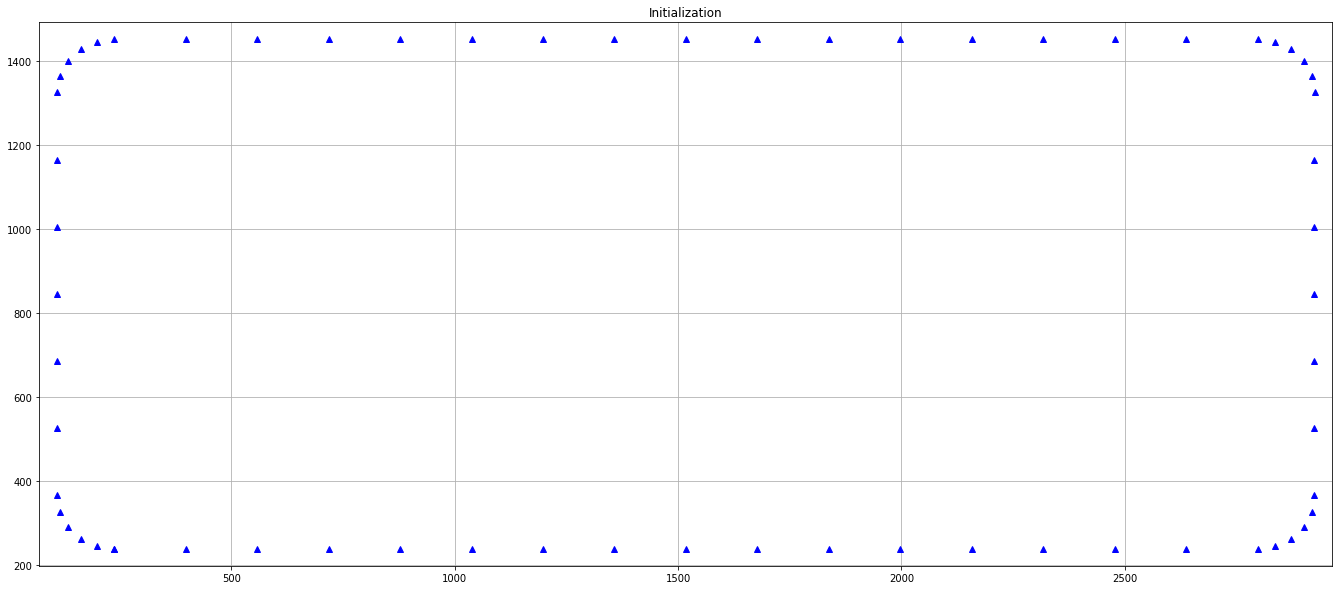

Initial chi2: 553.9602439927149
L: 0 predicted chi2: 0.022018468621580033
L: 0 chi2: 553.5134900987767 lambda: 7.008579101681072
Iteration 0 chi2: 553.5134900987767
L: 0 predicted chi2: 0.004284403638144309
L: 0 chi2: 553.2809680949115 lambda: 4.6723860677873805
Iteration 1 chi2: 553.2809680949115
L: 0 predicted chi2: 0.002007372566827588
L: 0 chi2: 553.1202100761034 lambda: 3.1149240451915867
Iteration 2 chi2: 553.1202100761034
L: 0 predicted chi2: 0.0010364514782688285
L: 0 chi2: 553.032674747962 lambda: 2.0766160301277243
Iteration 3 chi2: 553.032674747962
L: 0 predicted chi2: 0.0005311873228718074
L: 0 chi2: 552.9573205842444 lambda: 1.3844106867518162
Iteration 4 chi2: 552.9573205842444
L: 0 predicted chi2: 0.0003315589613599104
L: 0 chi2: 552.9265091790385 lambda: 0.9229404578345441
Iteration 5 chi2: 552.9265091790385
L: 0 predicted chi2: 0.000236384798323397
L: 0 chi2: 552.8870814565665 lambda: 0.6152936385563628
Iteration 6 chi2: 552.8870814565665
L: 0 predicted chi2: 0.0001902

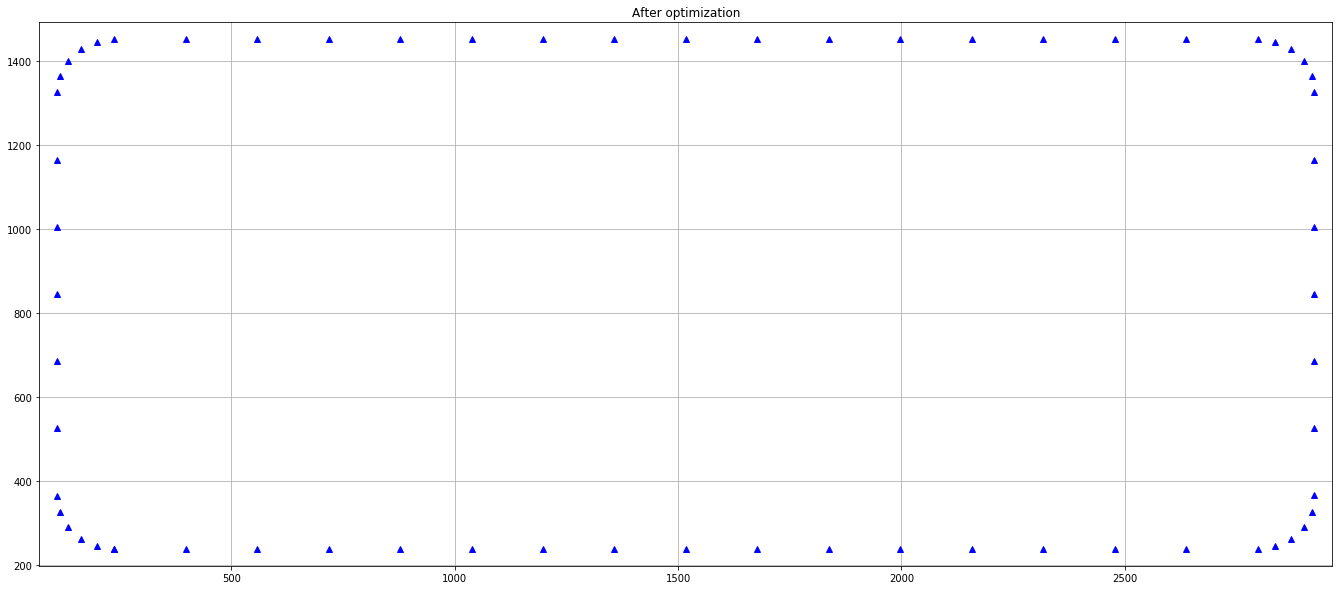

In [77]:
all_params = algorithm._all_params
if all_params is not None:
    all_params[::3] += 0.01 * np.random.randn(*(all_params[::3].shape))
    all_params[1::3] += 0.01
    algorithm._all_params = all_params

visualizator = Visualizator(grid=True)
visualizator.update_poses(algorithm.poses)
visualizator.update_features(algorithm.features)
visualizator.show('Initialization')

algorithm.optimize(300)
visualizator.update_poses(algorithm.poses)
visualizator.update_features(algorithm.features)
visualizator.show('After optimization')